**Grocery Auction**

# Introduction

- 주제: 농수산물 별 물가 상승 정도 분석 및 경매 가격 분석 시각화
- 목표: 데이터 분석 프로젝트 진행, 시각화로 포트폴리오 만들기
- 기간: 22/07/25 ~ 22/08/05
- 팀원: 이진규
- 데이터: 서울열린데이터광장 : 농수산물 경매 정보 (http://data.seoul.go.kr/dataList/OA-2662/S/1/datasetView.do#)

## column info

값 | 의미
---|:---:|
`prd` | 품목명, 카테고리별로 전처리 |
`scale` | 판매 단위 (kg) |
`price` | 판매 가격 (₩) |
`reg_date` | 등록일 |
`eco` | 친환경 표기* |
`new_class` | 상품 등급 (1~9)|
`price_kg` | kg 당 가격 |
`state` | 도단위, 해외는 수입으로 표기|
`city` | 시단위, 해외는 국가명 |


- *(eco)친환경 표기 설명

값 | 의미
---|:---:|
`normal` | 일반 |
`low` | 저농약 |
`ecofriendly` | 무농약 |
`organic` | 유기농 |
`good_prd` | 우수농산물 |
`certified` | 품질인증 |
`ing` | 전환기 (유기농으로 전환중)|
`safe` | 산지안전성|

## Initialize

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.options.display.float_format = '{:.5f}'.format
data = "/Users/luci031/Desktop/Coding/g_auction"

# matplotlib 폰트설정
plt.rc('font', family='AppleGothic') # For MacOS
# plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

plt.rcParams['axes.unicode_minus'] = False

['AppleGothic']


In [390]:
# 데이터 불러오기
df_lst = []
for i in range(1,19):
    if i < 13:
        if i < 10:
            name = "df210"+str(i)
            df_name = "20210"+str(i)
        else:
            name = "df21"+str(i)
            df_name = "2021"+str(i)
    else:
        a = i%12
        name = "df220"+str(a)
        df_name = "20220"+str(a)
    name = pd.read_csv(data+"/data_proceed/"+df_name+"_proceed.csv")
    df_lst.append(name)


In [391]:
# 보기 옵션
pd.set_option('display.max_rows', 30)
# pd.reset_option('display.max_rows')

## Pre-processing

In [392]:
# 데이터 전처리
for df in df_lst:
    df.reset_index(inplace=True,drop=True)
    df.drop(columns=['Unnamed: 0'],inplace=True)

In [393]:
# 모든 데이터 통합
df = df_lst[0]
for dfs in df_lst[1:]:
    df = pd.concat([df,dfs])
df.reset_index(inplace=True,drop=True)

In [394]:
# 기존 데이터의 전처리가 완료된 상태기 때문에 null값 없음
df.isnull().sum()

prd          0
scale        0
price        0
eco          0
reg_date     0
new_class    0
price_kg     0
state        0
city         0
dtype: int64

In [395]:
# scale 값이 0인 이상치 발견하여 삭제
df.drop(df[df['scale']==0].index,inplace=True)

In [396]:
# price_kg 비율이 35만원 이상 차이나는 값들 -> 이상치라 판단하고 제거
df.drop(df[df['price_kg']>=350000].index,inplace=True)

In [397]:
# reg_date datetime format으로 변경
df['reg_date'] = pd.to_datetime(df['reg_date'])

In [398]:
# eco 표기 문제 확인하여 전처리
df.loc[df["eco"]=="ecofriendly","eco"] = "ecofriendly"
df.loc[df["eco"]=="good_prd","eco"] = "good_prd"
df.loc[df["eco"]=="저농약","eco"] = "low"
df.loc[df["eco"]=="산지안전성","eco"] = "safe"

# EDA

## Basic Info

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11141363 entries, 0 to 11141588
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   prd        object        
 1   scale      float64       
 2   price      int64         
 3   eco        object        
 4   reg_date   datetime64[ns]
 5   new_class  int64         
 6   price_kg   float64       
 7   state      object        
 8   city       object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 850.0+ MB


In [400]:
df.describe()

,scale,price,new_class,price_kg
count,11141363.00000,11141363.00000,11141363.00000,11141363.00000
mean,8.45515,22818.41750,1.56490,4323.12101
std,120.90021,64154.21454,1.67265,5044.10626
min,0.02000,500.00000,1.00000,0.40000
25%,3.00000,8000.00000,1.00000,1600.00000
50%,5.00000,15000.00000,1.00000,2857.14000
75%,10.00000,27000.00000,1.00000,5222.22000
max,18000.00000,15000000.00000,9.00000,336000.00000


In [401]:
# 상관관계 탐색 (price_kg는 price로부터 생성된 계산값이기 때문에 제외)
# scale과 price가 상관관계가 꽤 있지만 생각보다 크진 않다 
df[['scale','price','new_class']].corr()

,scale,price,new_class
scale,1.00000,0.78910,-0.00314
price,0.78910,1.00000,-0.02433
new_class,-0.00314,-0.02433,1.00000


## Column 별 탐색

### reg_date

In [402]:
# 날짜별 데이터 분포 탐색
counter = df.groupby(['reg_date']).count()

In [403]:
# 거래가 1개 뿐인 날짜 발견 -> 전체 목록에서 삭제 -> 이후 다시 불러오기
df.drop(df[df['reg_date']=='2021-04-18'].index,inplace=True)
counter = df.groupby(['reg_date']).count()

In [404]:
# 일자별 거래량
df.groupby(['reg_date'])['prd'].count().describe()

count     451.00000
mean    24703.68514
std      9808.83866
min       501.00000
25%     17996.00000
50%     20959.00000
75%     34268.00000
max     50852.00000
Name: prd, dtype: float64

In [405]:
df[(df['reg_date']=='2021-06-28')&(df['prd']=='감귤')]

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
2531969,감귤,3.00000,23000,good_prd,2021-06-28,1,7666.67000,제주,제주
2531970,감귤,3.00000,18000,good_prd,2021-06-28,1,6000.00000,제주,제주
2531971,감귤,6.00000,16000,normal,2021-06-28,1,2666.67000,제주,제주
2531972,감귤,5.00000,18000,normal,2021-06-28,1,3600.00000,제주,제주
2531973,감귤,3.00000,22000,normal,2021-06-28,1,7333.33000,제주,제주
...,...,...,...,...,...,...,...,...,...
2532374,감귤,5.00000,8000,normal,2021-06-28,9,1600.00000,제주,제주
2532475,감귤,6.00000,38400,normal,2021-06-28,9,6400.00000,제주,제주
2532476,감귤,6.00000,37200,normal,2021-06-28,9,6200.00000,제주,제주
2532477,감귤,6.00000,38400,normal,2021-06-28,9,6400.00000,제주,제주


In [406]:
# 가장 거래량이 많은 날은 22년 6월 20일
# 거래량이 적은 날은 21년 6월 20일
c = df.groupby(['reg_date']).count()
c[(c['prd']==50852) | (c['prd']==501)]

,prd,scale,price,eco,new_class,price_kg,state,city
reg_date,,,,,,,,
2021-06-28,501,501,501,501,501,501,501,501
2022-06-20,50852,50852,50852,50852,50852,50852,50852,50852


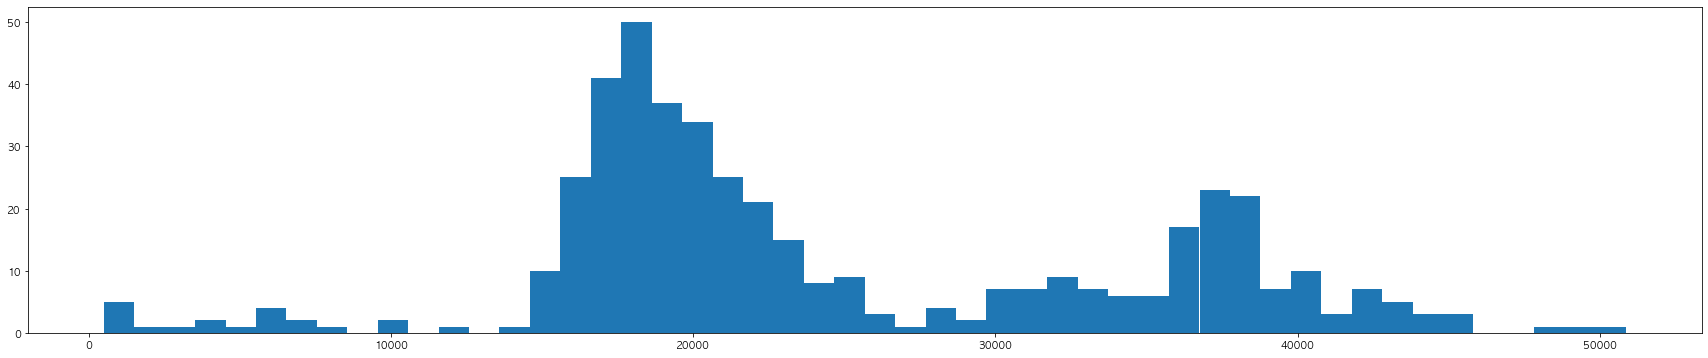

In [407]:
# 일자별 데이터 분포 1
# 평균적으로 15000~25000 건 사이의 거래가 이루어짐
plt.figure(figsize=(30,6))
plt.hist(c['prd'],bins=50)
plt.show()

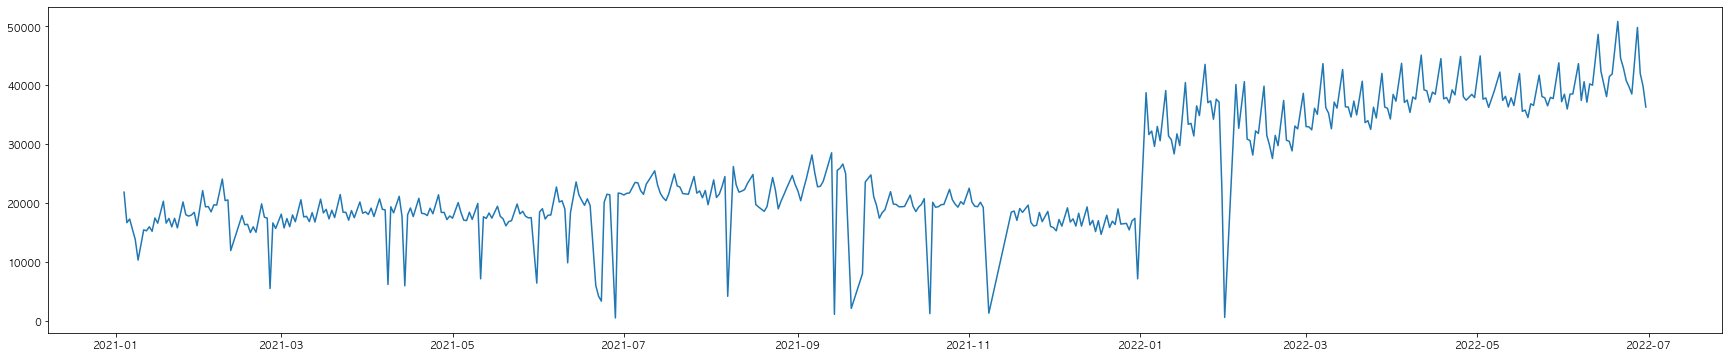

In [408]:
# 일자별 데이터 분포 2
# 데이터 양의 차이로 22년 거래가 상대적으로 더 많은 것 확인 -> 22년에 
# 주기적으로 거래량이 작은 날짜 확인 필요
plt.figure(figsize=(30,6))
plt.plot(c['prd'])
plt.show()

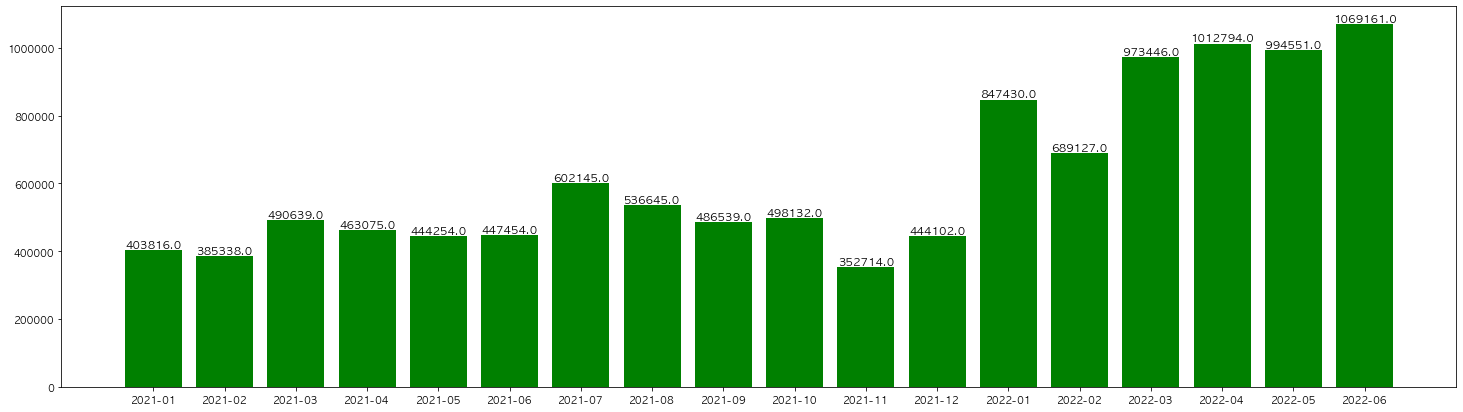

In [409]:
# 월별 거래 횟수
# 22년과 21년의 차이가 꽤 많이 난다
c.reset_index(inplace=True)
c['ym'] = c['reg_date'].dt.strftime('%Y-%m')
c.drop(columns=('reg_date'),inplace=True)
cc = c.groupby(c['ym']).sum()
cc.reset_index(inplace=True)
# 월별 거래량
plt.figure(figsize=(25,7))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,200)) 
bar = plt.bar(cc['ym'],cc['scale'],color='green')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 11)

plt.show()

In [413]:
# 공휴일 등의 날짜는 아닌 듯
# 특정 날짜들의 경우 전날 비가 오거나 했지만 특정성이 생길 정도는 아닌 듯
k = df.groupby(['reg_date']).count()
days = k[k['prd']<=10000].index.tolist()
days

[Timestamp('2021-02-25 00:00:00'),
 Timestamp('2021-04-08 00:00:00'),
 Timestamp('2021-04-14 00:00:00'),
 Timestamp('2021-05-11 00:00:00'),
 Timestamp('2021-05-31 00:00:00'),
 Timestamp('2021-06-11 00:00:00'),
 Timestamp('2021-06-21 00:00:00'),
 Timestamp('2021-06-22 00:00:00'),
 Timestamp('2021-06-23 00:00:00'),
 Timestamp('2021-06-28 00:00:00'),
 Timestamp('2021-08-07 00:00:00'),
 Timestamp('2021-09-14 00:00:00'),
 Timestamp('2021-09-20 00:00:00'),
 Timestamp('2021-09-24 00:00:00'),
 Timestamp('2021-10-18 00:00:00'),
 Timestamp('2021-11-08 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-31 00:00:00')]

In [414]:
# 일별로 확인 결과, 
from collections import defaultdict as d
week = ['월','화','수','목','금','토','일']
lst = d(int)
for day in days:
    a = week[day.weekday()]
    lst[a] += 1

# 상대적으로 월요일이 많긴 하나, 도드라질 정도는 아님
lst

defaultdict(int, {'목': 2, '수': 2, '화': 3, '월': 7, '금': 3, '토': 1})

In [415]:
# 주간 평균 판매량
def week_check(date):
    return date.weekday()
df2 = df['reg_date'].to_frame()
df2['week'] = df2['reg_date'].apply(week_check)

In [416]:
df2

,reg_date,week
0,2021-01-04,0
1,2021-01-04,0
2,2021-01-04,0
3,2021-01-04,0
4,2021-01-04,0
...,...,...
11141584,2022-06-29,2
11141585,2022-06-23,3
11141586,2022-06-24,4
11141587,2022-06-27,0


In [417]:
# 요일별 분포
aa = df2['week'].value_counts().to_frame()
aa.reset_index(inplace=True)
aa.rename(columns={'index':'day', 'week':'count'},inplace=True)
for i in range(len(week)):
    aa.loc[aa["day"]==i,"day"] = week[i]

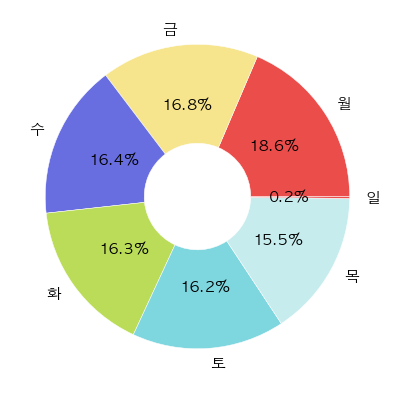

In [418]:
# 요일별 분포 시각화
# 전반적으로 비슷하나, 월요일에 조금 더 거래가 많다
plt.figure(figsize=(7,7),facecolor='white')
wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 0.5}
plt.rc('font', size=15) 
colors = ['#eb4d4b','#f6e58d','#686de0','#badc58','#7ed6df','#c7ecee']
plt.pie(aa['count'],labels=aa['day'],autopct='%.1f%%',wedgeprops=wedgeprops,colors=colors)
plt.show()

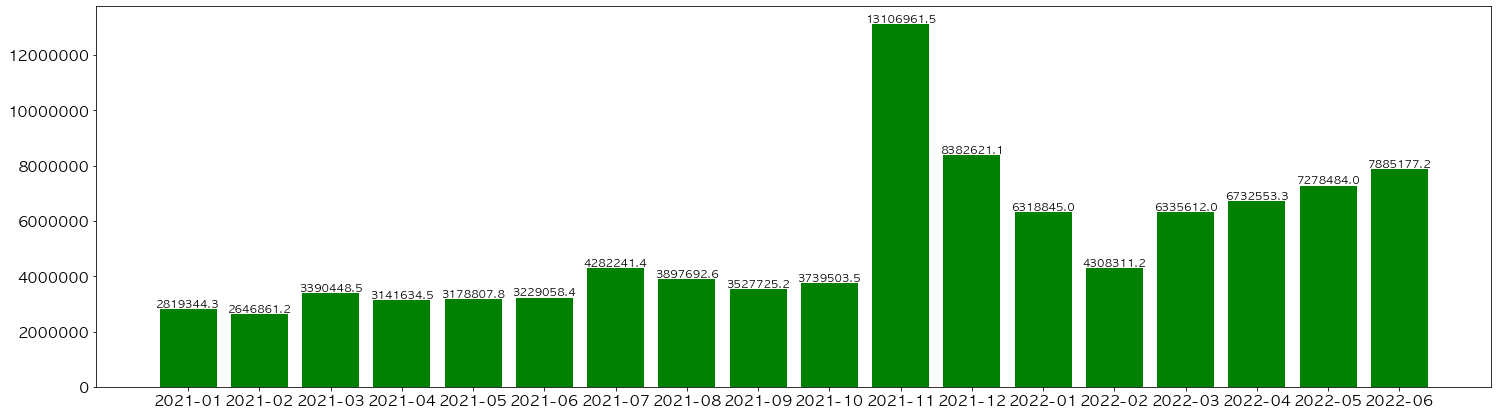

In [419]:
# 월별 총 거래량 탐색
dfm = df.groupby(['reg_date']).sum()[['scale','price']]
dfm.reset_index(inplace=True)
dfm['ym'] = dfm['reg_date'].dt.strftime('%Y-%m')
dfm.drop(columns=('reg_date'),inplace=True)
bb = dfm.groupby(dfm['ym']).sum()
bb.reset_index(inplace=True)
# 월별 거래량
plt.figure(figsize=(25,7))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,200)) 
bar = plt.bar(bb['ym'],bb['scale'],color='green')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 11)

plt.show()

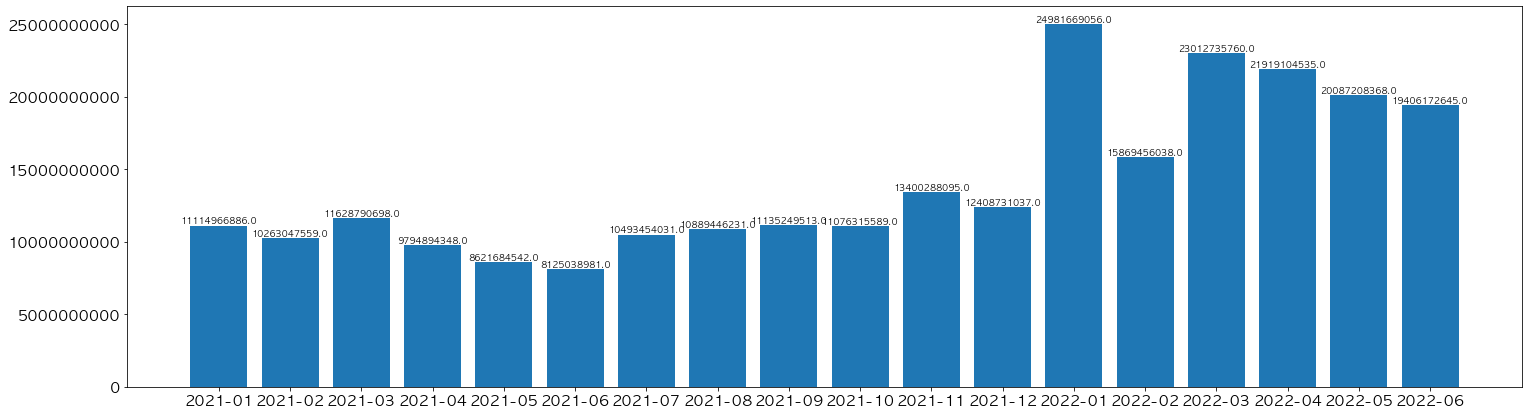

In [420]:
# 월별 총 거래 가격 탐색
plt.figure(figsize=(25,7))
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,11)) 
bar = plt.bar(bb['ym'],bb['price'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 9)
plt.show()

- 전반적으로 21년에 비해 22년 데이터가 많다보니 거래량도 더 많음
- 하지만 21년 11월에 김장 관련 품목들이 거래가 많이 되어 거래량이 가장 많았음
- 매출은 22년 1월에 가장 높았음 -> 2월엔 22년 들어 가장 낮았는데, 둘다 겨울에 거래가 이뤄졌으므로 날씨 때문은 아님

### 연속형 데이터 탐색 (Scale,Price,New_class,Price_kg)

In [421]:
# 대략적인 데이터 정보
df.describe()

,scale,price,new_class,price_kg
count,11141362.00000,11141362.00000,11141362.00000,11141362.00000
mean,8.45515,22818.41788,1.56490,4323.12123
std,120.90022,64154.21741,1.67265,5044.10643
min,0.02000,500.00000,1.00000,0.40000
25%,3.00000,8000.00000,1.00000,1600.00000
50%,5.00000,15000.00000,1.00000,2857.14000
75%,10.00000,27000.00000,1.00000,5222.22000
max,18000.00000,15000000.00000,9.00000,336000.00000


In [422]:
# scale TOP 10
df.sort_values('scale', ascending=False).head(10)

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
4881600,무,18000.00000,11000000,normal,2021-11-06,1,611.11000,전북,부안
4884303,무,10000.00000,2500000,normal,2021-11-26,1,250.00000,충남,서산
4884301,무,10000.00000,6500000,normal,2021-11-26,1,650.00000,전남,영암
4884300,무,10000.00000,3370000,normal,2021-11-26,1,337.00000,전북,부안
4884299,무,10000.00000,8510000,normal,2021-11-26,1,851.00000,전북,부안
4884298,무,10000.00000,8770000,normal,2021-11-26,1,877.00000,전북,부안
4884297,무,10000.00000,4030000,normal,2021-11-26,1,403.00000,전남,영암
5516730,무,10000.00000,1690000,normal,2021-12-10,1,169.00000,전북,고창
4884296,무,10000.00000,3880000,normal,2021-11-26,1,388.00000,전북,부안
4884295,무,10000.00000,2660000,normal,2021-11-26,1,266.00000,전북,부안


In [430]:
# price TOP 10
df.sort_values('price', ascending=False).head(10)

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
4882522,무,10000.00000,15000000,normal,2021-11-18,1,1500.00000,전남,무안
4882820,무,10000.00000,14500000,normal,2021-11-19,1,1450.00000,전남,무안
4883143,무,10000.00000,14000000,normal,2021-11-20,1,1400.00000,전남,무안
4882520,무,10000.00000,14000000,normal,2021-11-18,1,1400.00000,전남,무안
4882821,무,10000.00000,13500000,normal,2021-11-19,1,1350.00000,전북,부안
4881887,무,10000.00000,13100000,normal,2021-11-16,1,1310.00000,전남,무안
4882942,무,10000.00000,12900000,normal,2021-11-20,1,1290.00000,전남,무안
4882736,무,10000.00000,12000000,normal,2021-11-19,1,1200.00000,전남,무안
4881890,무,10000.00000,12000000,normal,2021-11-16,1,1200.00000,전남,무안
4881284,무,10000.00000,12000000,normal,2021-11-05,1,1200.00000,전북,부안


In [431]:
# price_kg TOP 1p
df.sort_values('price_kg', ascending=False).head(10)

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
11111567,체리,1.00000,336000,normal,2022-06-23,1,336000.00000,경북,안동
11111566,체리,1.00000,336000,normal,2022-06-23,1,336000.00000,경북,안동
11111532,체리,1.00000,336000,normal,2022-06-22,1,336000.00000,경북,안동
11111531,체리,1.00000,336000,normal,2022-06-22,1,336000.00000,경북,안동
11111530,체리,1.00000,336000,normal,2022-06-22,1,336000.00000,경북,안동
11111559,체리,1.00000,336000,normal,2022-06-23,1,336000.00000,경북,안동
11111560,체리,1.00000,336000,normal,2022-06-23,1,336000.00000,경북,안동
11111529,체리,1.00000,336000,normal,2022-06-22,1,336000.00000,경북,안동
11111568,체리,1.00000,336000,normal,2022-06-23,1,336000.00000,경북,안동
1666731,수박,2.00000,670013,normal,2021-04-29,1,335006.50000,대구,대구


In [424]:
# class 분포
class_count = df.groupby(['new_class']).count()
class_count['percent'] = class_count['prd']/len(df)
class_count[['prd','percent']]

,prd,percent
new_class,,
1,8930294,0.80154
2,1138002,0.10214
3,489919,0.04397
4,47363,0.00425
5,51337,0.00461
6,12316,0.00111
7,4413,0.00040
8,1338,0.00012
9,466380,0.04186


- Scale
    - 평균적인 거래량은 약 8.455 kg
    - 최소 거래량은 0.02 kg 짜리 거래 (느타리버섯, 깻잎)
    - 최대 1회 거래량은 18톤 가량의 '무' 거래
- Price (Price_kg)
    - 평균적인 거래 금액은 약 22818원
    - 최소 거래 금액을 500원으로 전처리 했기 때문에 500원
    - 최대 거래 금액은 15000000원의 '무' 거래, 10톤 거래되었음
- New_class
    - 평균적인 등급은 약 1.56 등급, 1급이 가장 높은 등급임을 감안하면 품질이 전체적으로 좋은 편
    - 전체적인 분포 및 표준편차로 봤을 때 1등급이 가장 많음 (80% 가량)

In [425]:
df[df['price']==15000000]

,prd,scale,price,eco,reg_date,new_class,price_kg,state,city
4882522,무,10000.00000,15000000,normal,2021-11-18,1,1500.00000,전남,무안


### prd

In [426]:
# 품목 수
len(df['prd'].unique())

207

In [427]:
# 물품별 거래 수 TOP 10
prd_sold = df.groupby(['prd']).count().reset_index()
prd_sold = prd_sold[['prd','scale']]
prd_sold.rename(columns={'scale':'count'},inplace=True)
prd_sold.sort_values('count', ascending=False).head(10)

,prd,count
58,딸기,872399
92,버섯,850523
148,오이,611242
186,토마토,574963
168,참외,505725
203,호박,427460
25,고추,425037
37,깻잎,406619
139,양채류,376880
108,상추,320189


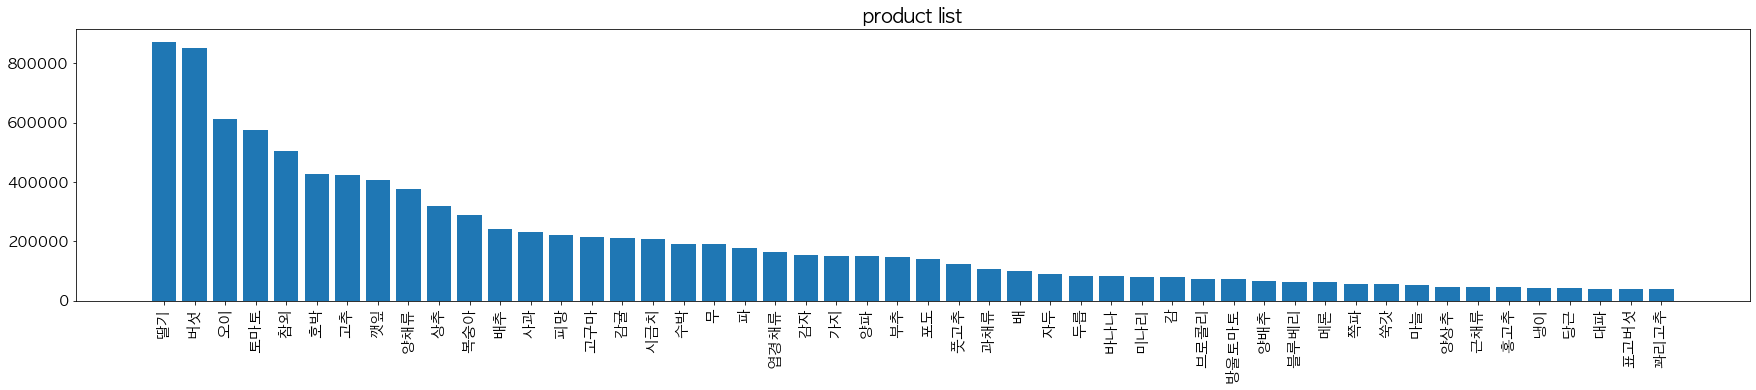

Product 종류 수: 207
Product 최대 거래 횟수: 872399
Product 최소 거래 횟수: 50


In [428]:
# 하스토그램을 이용해 Store를 시각화하여 품목들의 거래 횟수 분포 확인
plt.figure(figsize=(30,5))
plt.bar(prd_sold.sort_values('count',ascending=False).head(50)['prd'], prd_sold.sort_values('count',ascending=False).head(50)['count'])
plt.title("product list", size=20)
plt.xticks(rotation=90)
plt.show()

# 명확한 숫자를 확인하기 위해 수치를 출력
print(f"Product 종류 수: {len(df['prd'].unique())}")
print(f"Product 최대 거래 횟수: {df['prd'].value_counts().max()}")
print(f"Product 최소 거래 횟수: {df['prd'].value_counts().min()}")

In [429]:
# 품목별 판매량, 판매 가격 확인
# prd_sales = df.groupby(['prd']).agg(['sum','mean','max','min'])
# prd_sales
# plt.figure(figsize = (30,5))
# sns.histplot(prd_sales)
# plt.title("product sales", size=20)
# plt.xticks(rotation=90)
# plt.show()

# print('-Scale-')
# print(f"Product 평균 거래 무게: {prd_sales['scale'].mean()}")
# print(f"Product 최소 거래 무게: {prd_sales['scale'].min()}")
# print(f"Product 최대 거래 무게: {prd_sales['scale'].max()}")
# print('-Price')
# print(f"Product 평균 거래 가격: {prd_sales['price'].mean()}")
# print(f"Product 최소 거래 가격: {prd_sales['price'].min()}")
# print(f"Product 최대 거래 가격: {prd_sales['price'].max()}")